# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

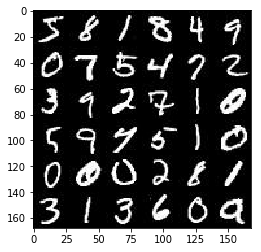

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

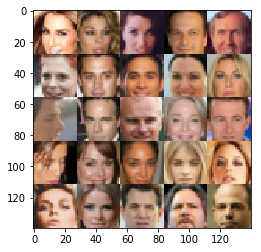

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    # Generator and Discriminator inputs
    real = tf.placeholder(dtype=tf.float32, shape=(None, image_height, image_width, image_channels), name="real_input")
    z = tf.placeholder(dtype=tf.float32, shape=(None,z_dim), name="z_input")
    
    # Learning rate
    lr = tf.placeholder(dtype=tf.float32, name="learning_rate")
    
    return real, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
from tensorflow.contrib.layers import dropout
""" Discriminator Hyperparameters:
      alpha: leaky_relu's alpha
      keep_prob: dropout
"""

# Activation functions:

def leaky_relu(x,alpha=0.2):
    return tf.maximum(x,x*alpha)

def swish(x):
    return tf.nn.sigmoid(x) * x

# Convolution Layer
def conv(layer, filters, kernel_size=5, strides=2, padding="same", activation=None):
    # initializer
    xavier_initializer = tf.contrib.layers.xavier_initializer()

    # dropout batch_norm, conv, leaky
    layer = dropout(layer, keep_prob=keep_prob, is_training=True)
    layer = tf.layers.batch_normalization(layer, training = True)
    layer = tf.layers.conv2d(layer, filters, kernel_size, strides=strides, padding=padding, activation=None, kernel_initializer=xavier_initializer)
    layer = leaky_relu(layer, alpha)
    
    #print(layer.get_shape())
    

    return layer


# # # # # # # # # # # #

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        # Controls
        alpha = 0.2
        keep_prob = .8

        # Layers
        xavier_initializer = tf.contrib.layers.xavier_initializer()
        layer = tf.layers.conv2d(images, 32, 3, strides=2, padding="same", activation=None, kernel_initializer=xavier_initializer)
        
        layer = conv(layer, 64, kernel_size=3) # 14x14x64
        layer = conv(layer, 128, kernel_size=3) # 7x7x128
        layer = conv(layer, 256, kernel_size=3) # 4x4x256
        
        layer = conv(layer, 512, kernel_size=3) # 2x2x512
        
        # logits, output
        flat = tf.reshape(layer, (-1,512)) #changed from 1024 -> 512
        logits = tf.layers.dense(flat,1)
        output = tf.sigmoid(logits)
    

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    
    # Controls
    alpha = 0.2
    keep_prob = 0.9

    def conv_T(layer, filters, strides=2, padding='same', kernel_size=5, use_bias=False):

        xavier_initializer = tf.contrib.layers.xavier_initializer()
        layer = dropout(layer, keep_prob=keep_prob, is_training=is_train)
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.layers.conv2d_transpose(layer, filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=use_bias, activation=None, kernel_initializer=xavier_initializer)

        layer = leaky_relu(layer, alpha)

        
        return layer

    with tf.variable_scope('generator', reuse=reuse):  
        
        # Structure
        # dense -> reshape
        layer = tf.layers.dense(z, 2**13, activation=None) # activation used to be tanh
        layer = tf.reshape(layer, (-1,4,4,512)) # (4x4x512)
        
        # Convolution Layers
        layer = conv_T(layer, 256, strides=1, padding='valid', kernel_size=4) # (7x7x256)
        layer = conv_T(layer, 128, kernel_size=3)   # (14x14x128)
        layer = conv_T(layer, 64, kernel_size=3)    # (28x28x64)
        
        # single strides convolutions
        layer = conv_T(layer, 32, strides=1, kernel_size=3)    # (28x28x32)
        layer = conv_T(layer, 16, strides=1, kernel_size=3)    # (28x28x16)
        
        logits = tf.layers.conv2d_transpose(layer, out_channel_dim, 2, strides=1, padding='same', use_bias=False, activation=None)      
        output = tf.tanh(logits)

       
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Models & Logits
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Label Smoothing
    smooth = .1
    labels_smoothed = tf.ones_like(d_model_real) * (1-smooth)
    
    # Discriminator losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_smoothed))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Generator losses
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get Weights and Bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    # Optimize                                  
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # get inputs
    n_samples, width, height, depth = data_shape
    real_input, z_input, lr = model_inputs(width, height, depth, z_dim)
    
    # normalize the real input [-.5,.5]->[-1,1] to match the generator output (tanh~)
    real_input_normalized = 2 * real_input
    
    # optimize
    d_loss, g_loss = model_loss(real_input_normalized, z_input, depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        samples, losses = [], []
        steps = 0
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1,1,(batch_size, z_dim))
                
                discriminator = sess.run(d_opt, feed_dict={real_input:batch_images, z_input: batch_z, lr: learning_rate})
                generator = sess.run(g_opt, feed_dict={real_input:batch_images, z_input: batch_z, lr: learning_rate})
                
                # Boost for the generator
                # if steps > 100 * batch_size:
                #     generator = sess.run(g_opt, feed_dict={real_input:batch_images, z_input: batch_z, lr: learning_rate})
              
                # Losses
                if steps % 100 == 0 or steps == 1:
                    
                    # Print losses
                    dloss = d_loss.eval({real_input: batch_images, z_input: batch_z, lr: learning_rate})
                    gloss = g_loss.eval({z_input: batch_z})
                    losses.append((dloss,gloss))
                    
                    print("step: {}, epoch: {}/{}".format(steps,epoch_i+1,epoch_count),
                          "Loss => Discriminator: {:.6f}, Generator: {:.6f}".format(dloss,gloss))
                
                    # Print generator output
                    if (steps % 200 == 0) or (steps == 1):
                        show_generator_output(sess, 16, z_input,depth,data_image_mode)
        
        # Final Report:
        print("\n#############\nFinal Results:\n#############")
        show_generator_output(sess, 50, z_input, depth, data_image_mode)
        
        print("\n#############\nLosses:\n#############")
        fig, ax = plt.subplots()
        losses = np.array(losses).T
        plt.plot(losses[0], label='Discriminator')
        plt.plot(losses[1], label='Generator')
        plt.title("Training Losses")
        plt.legend() 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

step: 1, epoch: 1/2 Loss => Discriminator: 1.575401, Generator: 0.474368


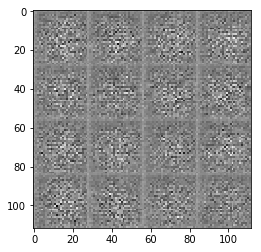

step: 100, epoch: 1/2 Loss => Discriminator: 1.228346, Generator: 0.903905
step: 200, epoch: 1/2 Loss => Discriminator: 1.290452, Generator: 0.690230


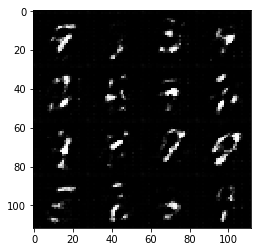

step: 300, epoch: 1/2 Loss => Discriminator: 1.370583, Generator: 0.841809
step: 400, epoch: 1/2 Loss => Discriminator: 1.450045, Generator: 0.666164


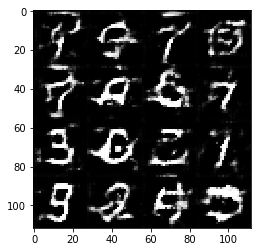

step: 500, epoch: 1/2 Loss => Discriminator: 1.083918, Generator: 0.918393
step: 600, epoch: 1/2 Loss => Discriminator: 1.305383, Generator: 1.095758


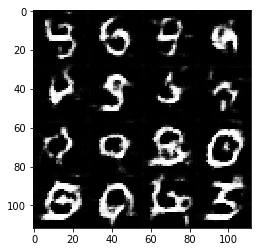

step: 700, epoch: 1/2 Loss => Discriminator: 0.973504, Generator: 1.010489
step: 800, epoch: 1/2 Loss => Discriminator: 1.267828, Generator: 0.740972


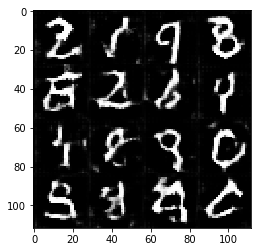

step: 900, epoch: 1/2 Loss => Discriminator: 1.166403, Generator: 1.281722
step: 1000, epoch: 1/2 Loss => Discriminator: 1.054012, Generator: 1.135673


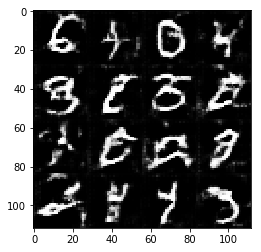

step: 1100, epoch: 1/2 Loss => Discriminator: 1.404128, Generator: 0.624478
step: 1200, epoch: 1/2 Loss => Discriminator: 1.320509, Generator: 0.694050


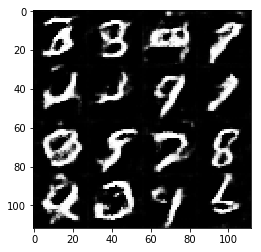

step: 1300, epoch: 1/2 Loss => Discriminator: 0.929502, Generator: 0.862061
step: 1400, epoch: 1/2 Loss => Discriminator: 1.075893, Generator: 0.786585


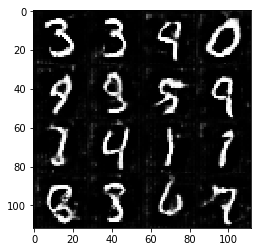

step: 1500, epoch: 1/2 Loss => Discriminator: 1.126114, Generator: 0.862668
step: 1600, epoch: 1/2 Loss => Discriminator: 1.661718, Generator: 0.796398


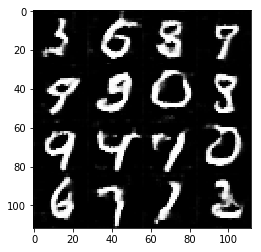

step: 1700, epoch: 1/2 Loss => Discriminator: 1.062169, Generator: 0.917309
step: 1800, epoch: 1/2 Loss => Discriminator: 1.045074, Generator: 0.734229


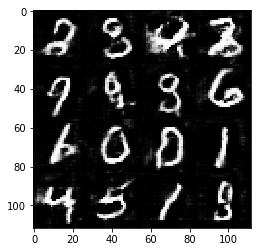

step: 1900, epoch: 2/2 Loss => Discriminator: 0.947275, Generator: 1.086279
step: 2000, epoch: 2/2 Loss => Discriminator: 1.218627, Generator: 1.326120


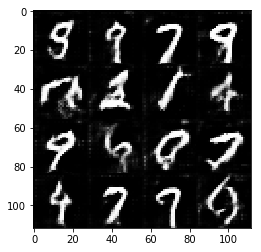

step: 2100, epoch: 2/2 Loss => Discriminator: 1.232018, Generator: 0.685776
step: 2200, epoch: 2/2 Loss => Discriminator: 1.014151, Generator: 0.676768


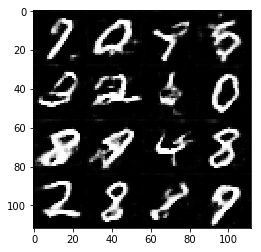

step: 2300, epoch: 2/2 Loss => Discriminator: 0.940321, Generator: 1.072484
step: 2400, epoch: 2/2 Loss => Discriminator: 1.052515, Generator: 0.718085


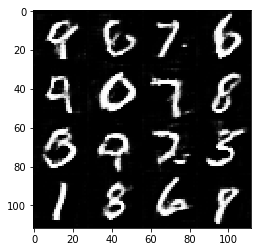

step: 2500, epoch: 2/2 Loss => Discriminator: 1.255606, Generator: 0.541999
step: 2600, epoch: 2/2 Loss => Discriminator: 1.189589, Generator: 0.855488


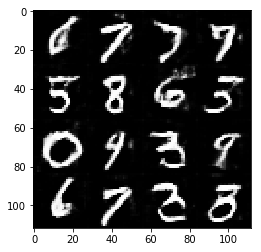

step: 2700, epoch: 2/2 Loss => Discriminator: 1.335786, Generator: 1.095386
step: 2800, epoch: 2/2 Loss => Discriminator: 1.182860, Generator: 0.639967


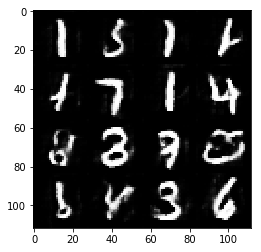

step: 2900, epoch: 2/2 Loss => Discriminator: 1.372041, Generator: 1.347215
step: 3000, epoch: 2/2 Loss => Discriminator: 0.858266, Generator: 1.161987


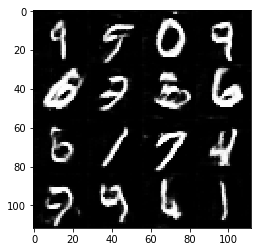

step: 3100, epoch: 2/2 Loss => Discriminator: 1.099901, Generator: 0.892021
step: 3200, epoch: 2/2 Loss => Discriminator: 1.062160, Generator: 1.349060


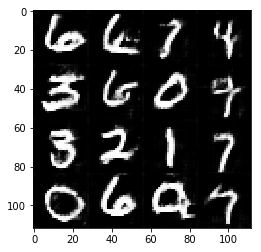

step: 3300, epoch: 2/2 Loss => Discriminator: 0.870797, Generator: 1.176182
step: 3400, epoch: 2/2 Loss => Discriminator: 1.292070, Generator: 0.723832


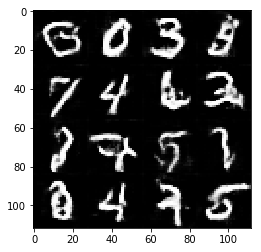

step: 3500, epoch: 2/2 Loss => Discriminator: 1.546683, Generator: 1.118353
step: 3600, epoch: 2/2 Loss => Discriminator: 1.411229, Generator: 0.672367


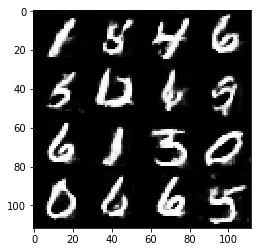

step: 3700, epoch: 2/2 Loss => Discriminator: 1.105224, Generator: 1.015791

#############
Final Results:
#############


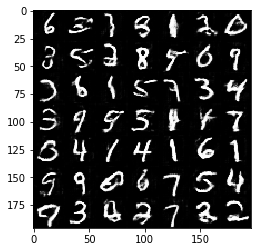


#############
Losses:
#############


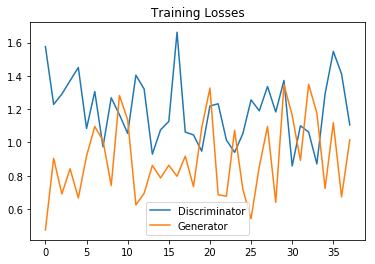

In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008

beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

step: 1, epoch: 1/1 Loss => Discriminator: 1.274196, Generator: 0.649948


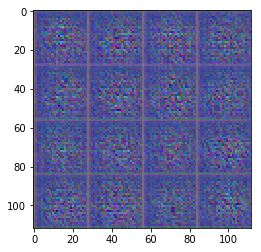

step: 100, epoch: 1/1 Loss => Discriminator: 1.352364, Generator: 0.965789
step: 200, epoch: 1/1 Loss => Discriminator: 0.939333, Generator: 2.005586


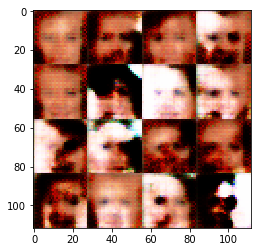

step: 300, epoch: 1/1 Loss => Discriminator: 0.974564, Generator: 1.098685
step: 400, epoch: 1/1 Loss => Discriminator: 1.109919, Generator: 1.190310


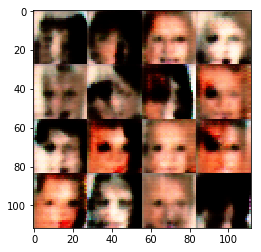

step: 500, epoch: 1/1 Loss => Discriminator: 1.069402, Generator: 1.294697
step: 600, epoch: 1/1 Loss => Discriminator: 1.208831, Generator: 0.984377


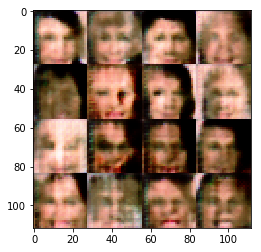

step: 700, epoch: 1/1 Loss => Discriminator: 1.249680, Generator: 1.261688
step: 800, epoch: 1/1 Loss => Discriminator: 0.951773, Generator: 1.143444


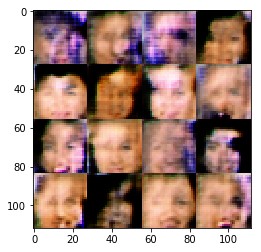

step: 900, epoch: 1/1 Loss => Discriminator: 1.291718, Generator: 0.792095
step: 1000, epoch: 1/1 Loss => Discriminator: 1.238979, Generator: 0.693653


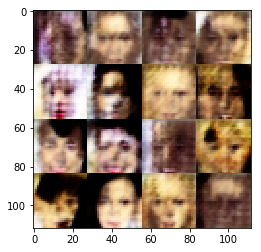

step: 1100, epoch: 1/1 Loss => Discriminator: 1.378763, Generator: 0.707138
step: 1200, epoch: 1/1 Loss => Discriminator: 1.339573, Generator: 0.722406


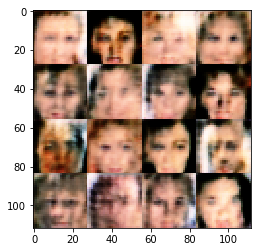

step: 1300, epoch: 1/1 Loss => Discriminator: 1.346836, Generator: 0.827261
step: 1400, epoch: 1/1 Loss => Discriminator: 1.272187, Generator: 1.087173


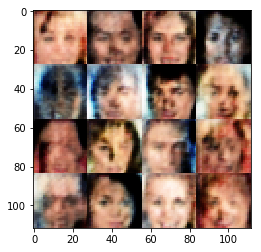

step: 1500, epoch: 1/1 Loss => Discriminator: 1.223462, Generator: 1.112178
step: 1600, epoch: 1/1 Loss => Discriminator: 1.395463, Generator: 0.897764


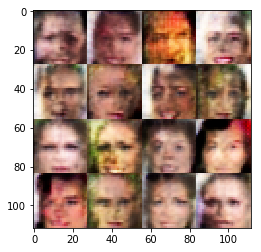

step: 1700, epoch: 1/1 Loss => Discriminator: 1.241039, Generator: 0.868502
step: 1800, epoch: 1/1 Loss => Discriminator: 1.303131, Generator: 1.070324


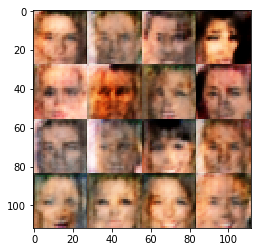

step: 1900, epoch: 1/1 Loss => Discriminator: 1.152558, Generator: 1.134520
step: 2000, epoch: 1/1 Loss => Discriminator: 1.177966, Generator: 1.031026


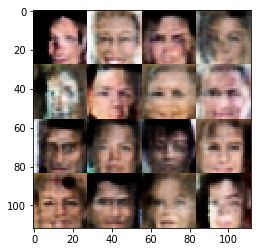

step: 2100, epoch: 1/1 Loss => Discriminator: 1.217984, Generator: 1.069077
step: 2200, epoch: 1/1 Loss => Discriminator: 1.207706, Generator: 0.866819


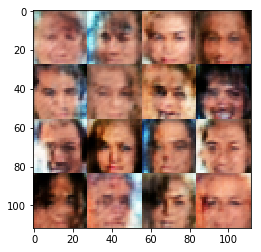

step: 2300, epoch: 1/1 Loss => Discriminator: 1.093747, Generator: 0.956191
step: 2400, epoch: 1/1 Loss => Discriminator: 1.392453, Generator: 0.785129


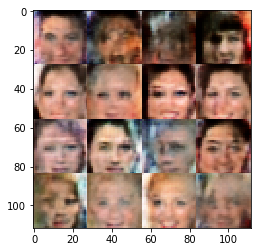

step: 2500, epoch: 1/1 Loss => Discriminator: 1.386256, Generator: 0.904745
step: 2600, epoch: 1/1 Loss => Discriminator: 1.280202, Generator: 0.917933


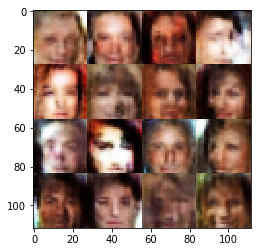

step: 2700, epoch: 1/1 Loss => Discriminator: 1.264409, Generator: 0.968011
step: 2800, epoch: 1/1 Loss => Discriminator: 1.228173, Generator: 1.079258


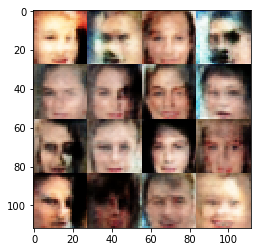

step: 2900, epoch: 1/1 Loss => Discriminator: 1.201029, Generator: 0.961048
step: 3000, epoch: 1/1 Loss => Discriminator: 1.308751, Generator: 1.021555


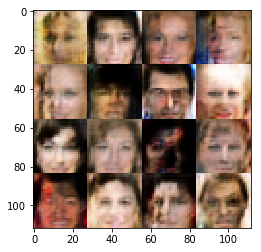

step: 3100, epoch: 1/1 Loss => Discriminator: 1.314980, Generator: 0.951352
step: 3200, epoch: 1/1 Loss => Discriminator: 1.312602, Generator: 0.913081


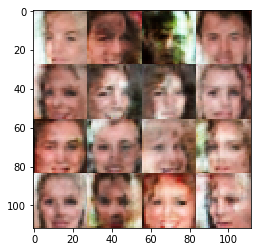

step: 3300, epoch: 1/1 Loss => Discriminator: 1.283761, Generator: 0.838786
step: 3400, epoch: 1/1 Loss => Discriminator: 1.329792, Generator: 0.810441


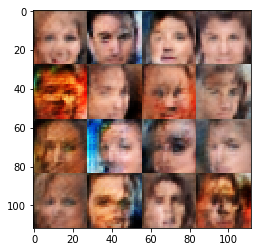

step: 3500, epoch: 1/1 Loss => Discriminator: 1.402496, Generator: 0.731206
step: 3600, epoch: 1/1 Loss => Discriminator: 1.342275, Generator: 0.914787


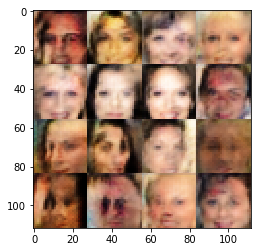

step: 3700, epoch: 1/1 Loss => Discriminator: 1.259920, Generator: 0.897669
step: 3800, epoch: 1/1 Loss => Discriminator: 1.306054, Generator: 0.913397


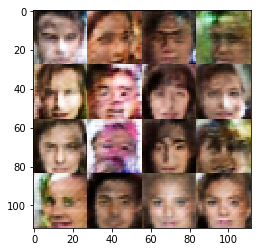

step: 3900, epoch: 1/1 Loss => Discriminator: 1.331659, Generator: 0.935717
step: 4000, epoch: 1/1 Loss => Discriminator: 1.380107, Generator: 0.902623


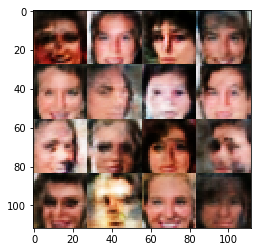

step: 4100, epoch: 1/1 Loss => Discriminator: 1.349756, Generator: 0.854716
step: 4200, epoch: 1/1 Loss => Discriminator: 1.273852, Generator: 0.986585


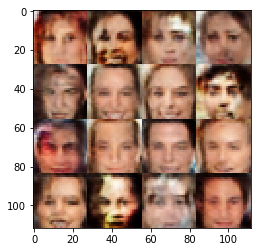

step: 4300, epoch: 1/1 Loss => Discriminator: 1.415398, Generator: 0.850007
step: 4400, epoch: 1/1 Loss => Discriminator: 1.402372, Generator: 0.741809


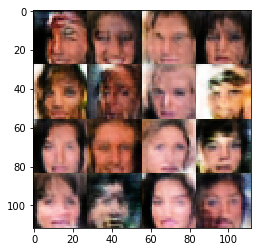

step: 4500, epoch: 1/1 Loss => Discriminator: 1.286729, Generator: 0.775988
step: 4600, epoch: 1/1 Loss => Discriminator: 1.297511, Generator: 0.896029


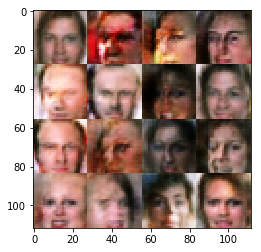

step: 4700, epoch: 1/1 Loss => Discriminator: 1.370418, Generator: 0.896637
step: 4800, epoch: 1/1 Loss => Discriminator: 1.385074, Generator: 0.783694


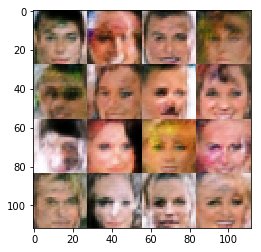

step: 4900, epoch: 1/1 Loss => Discriminator: 1.361908, Generator: 0.932130
step: 5000, epoch: 1/1 Loss => Discriminator: 1.301470, Generator: 0.837406


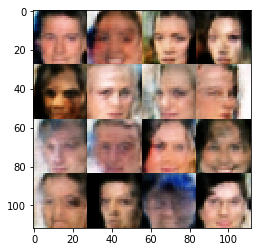

step: 5100, epoch: 1/1 Loss => Discriminator: 1.353562, Generator: 0.754785
step: 5200, epoch: 1/1 Loss => Discriminator: 1.445475, Generator: 0.831718


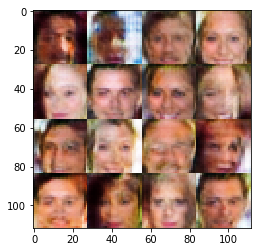

step: 5300, epoch: 1/1 Loss => Discriminator: 1.374373, Generator: 0.728929
step: 5400, epoch: 1/1 Loss => Discriminator: 1.244692, Generator: 0.852647


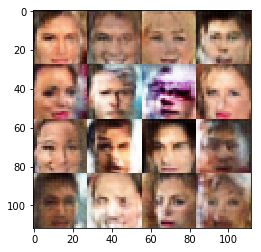

step: 5500, epoch: 1/1 Loss => Discriminator: 1.219831, Generator: 0.854870
step: 5600, epoch: 1/1 Loss => Discriminator: 1.452231, Generator: 0.807373


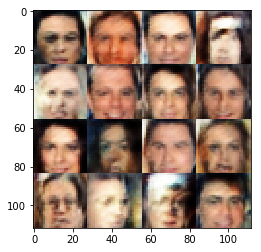

step: 5700, epoch: 1/1 Loss => Discriminator: 1.334092, Generator: 0.875517
step: 5800, epoch: 1/1 Loss => Discriminator: 1.357676, Generator: 0.799722


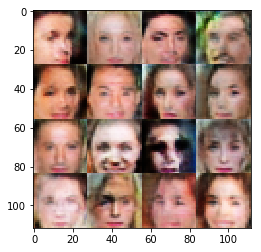

step: 5900, epoch: 1/1 Loss => Discriminator: 1.255841, Generator: 0.883552
step: 6000, epoch: 1/1 Loss => Discriminator: 1.313580, Generator: 0.850075


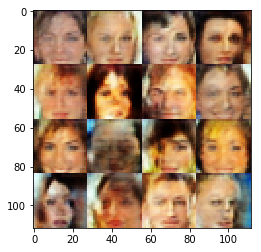

step: 6100, epoch: 1/1 Loss => Discriminator: 1.297065, Generator: 0.818656
step: 6200, epoch: 1/1 Loss => Discriminator: 1.369043, Generator: 0.822741


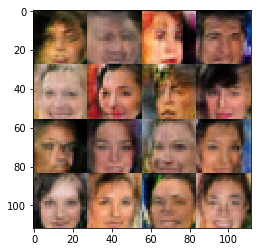

step: 6300, epoch: 1/1 Loss => Discriminator: 1.316984, Generator: 0.834273

#############
Final Results:
#############


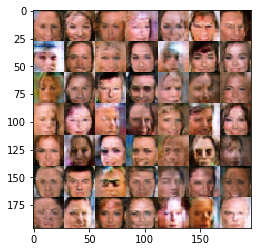


#############
Losses:
#############


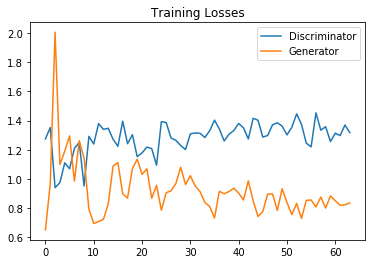

In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

# NOTES

resources used:
* Deep Learning=> Ian Goodfellow, Yoshua Bengio, and Aaron Courville", Chapter 12: Generative Adversarial Networks, p690
* Generative Adversarial Nets => by Goodfellow et al, 2014 [paper on arxiv.org](https://arxiv.org/abs/1406.2661)
* GAN Hacks => [Github - soutmith](https://github.com/soumith/ganhacks#2-a-modified-loss-function)
* Implementing a Generative Adversarial Network (GAN/DCGAN) to Draw Human Faces => [article](https://towardsdatascience.com/implementing-a-generative-adversarial-network-gan-dcgan-to-draw-human-faces-8291616904a), [github](https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/DCGAN-face-creation.ipynb)
* DLND #Project_5 Slack channel => [this comment](https://nd101.slack.com/archives/C3QVCQHGW/p1508699907000007)
* Bolts and Nuts of Applying deep Learning (by Andrew Ng) [youtube vid](https://www.youtube.com/watch?v=F1ka6a13S9I)

# Reference images:

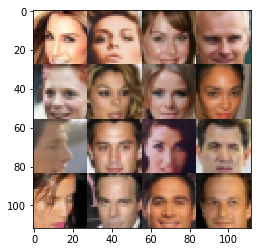

In [15]:
def show_img(show_n_images = 16, data='mnist'):
    if data == 'mnist':
        mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
        pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')
    else:
        data = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
        pyplot.imshow(helper.images_square_grid(data, 'RGB'))
        
    
show_img(data='celeba')


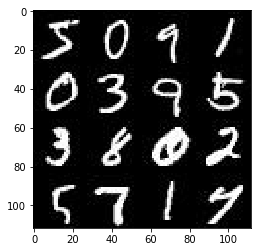

In [16]:
show_img(show_n_images = 16, data='mnist')